In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from utils_create_news import  save_s3, try_load
from utils_create_news import try_load
from sklearn.decomposition import PCA
from dotenv import load_dotenv
from minio import Minio

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import os

/Users/dan/.matplotlib is not a writable directory
Matplotlib created a temporary cache directory at /var/folders/6p/bshr1_dj3_7_gk1krflr4lzm0000gn/T/matplotlib-zw7i9dvc because there was an issue with the default path (/Users/dan/.matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


# 1. Инициализация и загрузка данных

In [2]:
load_dotenv()

DEEPSEEK_API_KEY = os.getenv("DEEPSEEK_API_KEY")
YANDEX_CLOUD_ACCESS_KEY = os.getenv("AWS_ACCESS_KEY_ID")
YANDEX_CLOUD_SECRET_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")

BUCKET_NAME = 'graduate' # s3

PATH = '/Users/dan/git_repo/graduate/'

In [3]:
client_s3 = Minio(
    "storage.yandexcloud.net",
    access_key=YANDEX_CLOUD_ACCESS_KEY,
    secret_key=YANDEX_CLOUD_SECRET_KEY,
    secure=True
)

In [4]:
# Оригинальные новости
vec_guardian_politic_clean_news = try_load(file_path=PATH+'data/', file_name='vec_guardian_politic_clean_news.pkl', client_s3=client_s3)

# Переписанные оригинальные моделью deepseek
vec_deepseek_api_rewrite_texts = try_load(file_path=PATH+'data/', file_name='vec_deepseek_api_rewrite_texts.pkl', client_s3=client_s3)

# Переписанные оригинальные моделью phi 3.5
vec_phi35_dsv3_if_texts = try_load(file_path=PATH+'data/', file_name='vec_phi35_dsv3_if_texts.pkl', client_s3=client_s3)

# Новости придуманные моделью deepseek
vec_deepseek_write_long_papers = try_load(file_path=PATH+'data/', file_name='vec_deepseek_write_long_papers.pkl', client_s3=client_s3)

# 2. Подготовка данных

In [ ]:
# Первый подход разделения (случайный)

# Подготовим источники новостей
# orig_news = list(vec_guardian_politic_clean_news.values())
# orig_news = np.vstack(orig_news)

# ds_rewrite = list(vec_deepseek_api_rewrite_texts.values())
# ds_rewrite = np.vstack(ds_rewrite)

# phi_rewrite = list(vec_phi35_dsv3_if_texts.values())
# phi_rewrite = np.vstack(phi_rewrite)

# ds_create = list(vec_deepseek_write_long_papers.values())
# ds_create = np.vstack(ds_create)

# # Объединим сгенерированные новости
# generated_news = np.concatenate((ds_rewrite, phi_rewrite, ds_create), axis=0)

# # Соберем датасет с разметкой
# orig_news = pd.DataFrame(orig_news)
# orig_news['orig_flg'] = 1

# generated_news = pd.DataFrame(generated_news)
# generated_news['orig_flg'] = 0

# data = pd.concat([orig_news, generated_news])

# data

# train, test = train_test_split(data, test_size=0.2, shuffle=True, stratify=data['orig_flg'])

# X_train = train.drop('orig_flg', axis=1)
# y_train = train['orig_flg'].values

# X_test = test.drop('orig_flg', axis=1)
# y_test = test['orig_flg'].values

In [6]:
# Второй подход
guard_keys = list(vec_guardian_politic_clean_news.keys())

guard_train, guard_test = train_test_split(guard_keys, test_size=0.2, shuffle=True)

# Оригинальные новости
guard_train_vec = [vec_guardian_politic_clean_news[key] for key in guard_train]
guard_test_vec = [vec_guardian_politic_clean_news[key] for key in guard_test]

guard_test_vec = pd.DataFrame(np.array(guard_test_vec)[:, 0, :])
guard_test_vec['orig_flg'] = 1

guard_train_vec = pd.DataFrame(np.array(guard_train_vec)[:, 0, :])
guard_train_vec['orig_flg'] = 1

# Переписанные новости
## Переписанные Deepseek v3
dsv3_rw_train = [vec_deepseek_api_rewrite_texts[key] for key in guard_train if key in vec_deepseek_api_rewrite_texts.keys()]
dsv3_rw_test = [vec_deepseek_api_rewrite_texts[key] for key in guard_test if key in vec_deepseek_api_rewrite_texts.keys()]

## Переписанные PHI 3.5
phi35_rw_train = [vec_phi35_dsv3_if_texts[key] for key in guard_train if key in vec_phi35_dsv3_if_texts.keys()]
phi35_rw_test = [vec_phi35_dsv3_if_texts[key] for key in guard_test if key in vec_phi35_dsv3_if_texts.keys()]

## Новоти созданные нейросеткой
dsv3_create = list(vec_deepseek_write_long_papers.values())
dsv3_create_train, dsv3_create_test = train_test_split(dsv3_create, test_size=0.2, shuffle=True)

generated_train_news = np.concatenate((dsv3_rw_train, phi35_rw_train, dsv3_create_train), axis=0)
generated_test_news = np.concatenate((dsv3_rw_test, phi35_rw_test, dsv3_create_test), axis=0)

generated_train_news = pd.DataFrame(np.array(generated_train_news)[:, 0, :])
generated_train_news['orig_flg'] = 0

generated_test_news = pd.DataFrame(np.array(generated_test_news)[:, 0, :])
generated_test_news['orig_flg'] = 0

# Сбор тренировочных и тестовых данных
train_data = pd.concat([
    guard_train_vec,
    generated_train_news
])

test_data = pd.concat([
    guard_test_vec,
    generated_test_news
])

train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

X_train = train_data.drop('orig_flg', axis=1)
y_train = train_data['orig_flg'].values

X_test = test_data.drop('orig_flg', axis=1)
y_test = test_data['orig_flg'].values

In [7]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,orig_flg
0,-0.092366,0.082537,0.040448,-0.099503,0.074382,-0.043670,-0.014904,0.070533,0.084822,-0.096845,...,-0.069048,-0.142406,-0.054913,0.060891,0.107865,-0.009892,-0.008748,-0.029871,-0.065042,0
1,-0.062672,0.095415,0.033980,-0.123512,0.073365,-0.096944,0.040372,-0.015115,0.080110,-0.123243,...,-0.083647,-0.090330,-0.036983,0.059733,0.091509,-0.003347,-0.070199,0.001125,-0.053985,1
2,-0.027878,0.082944,0.033057,-0.068363,0.110327,-0.126817,-0.023227,0.036239,0.058181,-0.085414,...,-0.037496,-0.099397,-0.039329,-0.023961,0.074548,0.127031,-0.101116,-0.083359,-0.025318,0
3,-0.070672,0.105633,0.055649,-0.109513,0.143799,-0.099717,0.003455,0.073239,0.051302,-0.156708,...,-0.041581,-0.077198,-0.061806,-0.003075,0.086916,0.003707,-0.084220,-0.006507,-0.035309,0
4,-0.054320,0.084029,0.010388,-0.101378,0.080618,-0.079900,0.020039,0.084195,0.056990,-0.103873,...,-0.047134,-0.026976,-0.065759,-0.010635,0.092022,0.022118,-0.067052,-0.019477,-0.063924,0


In [8]:
test_data.head()

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,orig_flg
0,-0.041189,0.087953,0.028195,-0.082623,0.054609,-0.062095,0.019197,0.066636,0.067763,-0.096320,...,-0.068419,-0.031989,-0.040036,0.058962,0.125172,-0.020142,-0.061922,-0.023997,-0.078355,0
1,-0.071961,0.059605,0.051796,-0.113882,0.130962,-0.076461,0.016010,0.052617,0.033543,-0.142581,...,-0.048550,-0.087138,-0.079302,0.066342,0.116083,-0.027638,-0.077811,0.007161,-0.088565,0
2,-0.050565,0.102402,0.024312,-0.143176,0.042591,-0.088633,-0.004520,0.073540,0.080647,-0.131955,...,-0.024202,-0.110394,-0.072746,0.074068,0.106474,0.015756,-0.037330,-0.020356,-0.089772,1
3,-0.072808,0.089277,0.064726,-0.080636,0.119653,-0.021007,-0.005268,0.014099,0.047751,-0.105574,...,-0.066103,-0.094101,-0.017523,0.056481,0.112488,0.028929,-0.024699,-0.015687,-0.036392,0
4,-0.104562,0.086031,0.061965,-0.119974,0.076864,-0.101910,0.016753,0.083466,0.059269,-0.098505,...,-0.012346,-0.074460,-0.027932,0.035885,0.108659,-0.010375,-0.036487,-0.005628,-0.093164,0


# 3. PCA

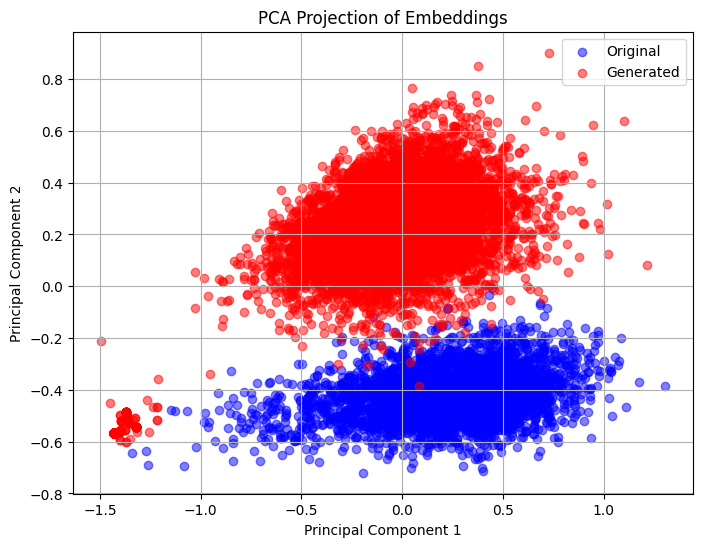

In [9]:
# Данные: эмбеддинги и метки
X = train_data.drop(columns=['orig_flg']).values
y = train_data['orig_flg'].values

# PCA до 2 компонент
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Визуализация
plt.figure(figsize=(8,6))
plt.scatter(X_pca[y==1, 0], X_pca[y==1, 1], color='blue', label='Original', alpha=0.5)
plt.scatter(X_pca[y==0, 0], X_pca[y==0, 1], color='red', label='Generated', alpha=0.5)
plt.legend()
plt.title('PCA Projection of Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# 4. Model

In [11]:
# Обучение логистической регрессии
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [16]:
# Предсказание вероятностей и классов
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Вероятность класса 1
y_pred = model.predict(X_test)  # Классы (0 или 1)

<Axes: >

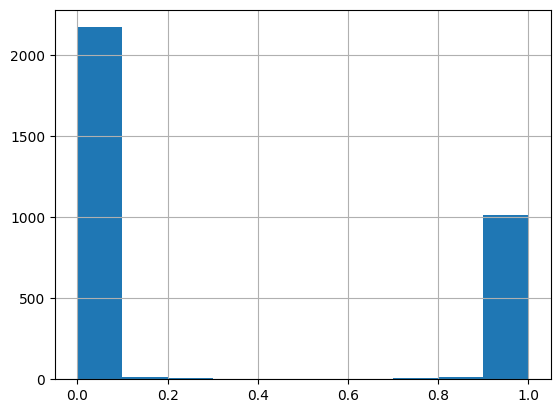

In [17]:
pd.Series(y_pred_proba).hist()

In [18]:
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    auc
)

In [19]:
# Основные метрики
print("Accuracy:", model.score(X_test, y_test))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))

Accuracy: 0.9990712074303405
ROC-AUC: 0.999968387776607
Precision: 0.9990375360923965
Recall: 0.9980769230769231
F1-score: 0.9985569985569985


orig_flg
0    Axes(0.125,0.11;0.775x0.77)
1    Axes(0.125,0.11;0.775x0.77)
Name: 217, dtype: object

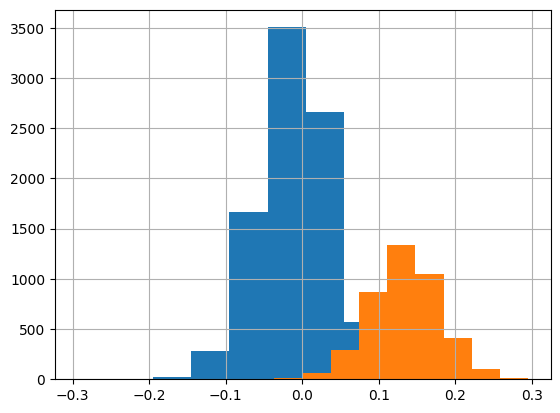

In [ ]:
# Признак по которому разделяются классы статей
train_data.groupby('orig_flg')[217].hist()

orig_flg
0    Axes(0.125,0.11;0.775x0.77)
1    Axes(0.125,0.11;0.775x0.77)
Name: 330, dtype: object

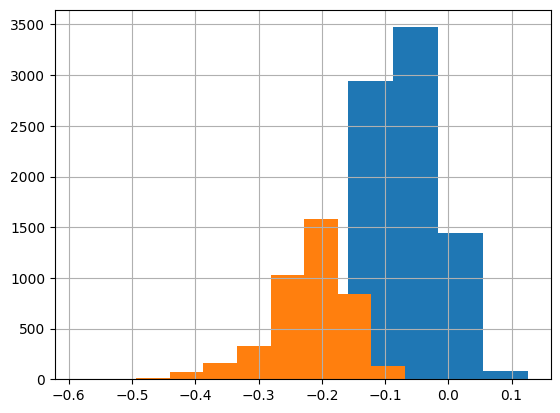

In [ ]:
# Признак по которому разделяются классы статей
train_data.groupby('orig_flg')[330].hist()

orig_flg
0    Axes(0.125,0.11;0.775x0.77)
1    Axes(0.125,0.11;0.775x0.77)
Name: 240, dtype: object

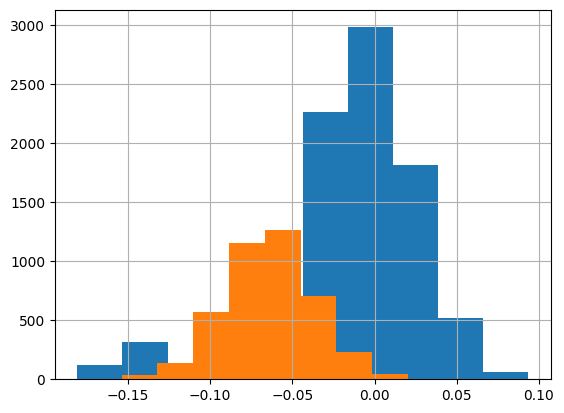

In [ ]:
# Признак по которому разделяются классы статей
train_data.groupby('orig_flg')[240].hist()

In [20]:
abs(pd.DataFrame(model.coef_).T).sort_values(0)

,0
232,0.000682
489,0.001487
262,0.002632
461,0.004474
21,0.004877
...,...
651,1.997957
453,2.170248
219,2.575014
330,3.526844


# 4. Ручной анализ

In [21]:
# Вектора вручную подготовленных статей
vec_test_cls_embedding = try_load(file_path=PATH+'data/', file_name='vec_test_cls_embedding.pkl', client_s3=client_s3)

pred_prob = model.predict_proba(vec_test_cls_embedding)[:, 1]

# 0.AI 1.AI 2.ORIG(GUARDIAN) 3.AI 4.ORIG(NYT) 5.ORIG(NYT) 6.AI
pd.Series(pred_prob)

0    0.002406
1    0.019137
2    0.999068
3    0.002841
4    0.551274
5    0.511910
6    0.000702
dtype: float64

___Оригинальные новости из которых были удалены артефакты новостной статьи___

In [28]:
# Новости оригинальные отредактированные dsv3 (удалены артефакты!)
vec_test_cls_embedding = try_load(file_path=PATH+'data/', file_name='vec_rewrited_orig_news_cls_embedding.pkl', client_s3=client_s3)

pred_prob = model.predict_proba(vec_test_cls_embedding)[:, 1]

pd.Series(pred_prob)

Загрузка данных из s3


0      0.995497
1      0.995497
2      0.997049
3      0.994840
4      0.993679
         ...   
98     0.995402
99     0.809897
100    0.987706
101    0.995686
102    0.996707
Length: 103, dtype: float64

<Axes: >

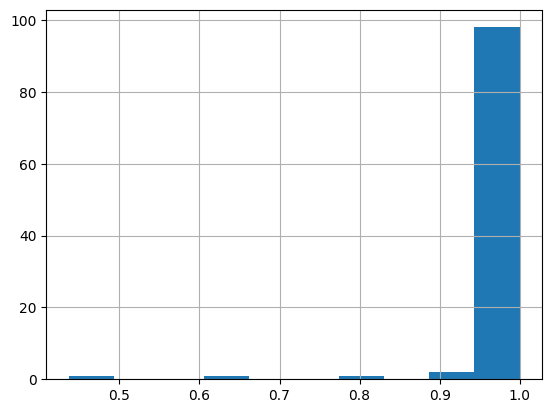

In [30]:
pd.Series(pred_prob).hist()

разбор какие статьи плохо определились как настоящие

In [57]:
# Оригинальная статья
deepseek_api_clear_orig_news = try_load(
    file_path=PATH+'/data/',
    file_name='deepseek_api_clear_orig_news.pkl',
    client_s3=client_s3
    )

# Оригинальная статья
deepseek_api_rewrite_texts = try_load(
    file_path=PATH+'/data/',
    file_name='deepseek_api_rewrite_texts.pkl',
    client_s3=client_s3
    )

pred_prob = pd.Series(pred_prob)
len(deepseek_api_clear_orig_news), len(pred_prob)

(102, 103)

In [51]:
data = pd.DataFrame(deepseek_api_clear_orig_news).T
data = pd.concat([data.reset_index(), pred_prob.drop_duplicates().reset_index(drop=True)], axis=1)
data.columns = ['id', 'titile', 'paper', 'orig_score']
data

,id,titile,paper,orig_score
0,politics/article/2024/jun/27/reform-uk-activis...,A Reform UK activist in the constituency where...,A Reform UK activist in the constituency where...,0.995497
1,politics/article/2024/jun/27/managers-who-sile...,NHS managers who silence and scapegoat whistle...,NHS managers who silence and scapegoat whistle...,0.997049
2,politics/article/2024/jun/27/the-farage-faithf...,Call it confirmation bias. The media were the ...,Call it confirmation bias. The media were the ...,0.994840
3,politics/article/2024/jun/27/labour-europe-eu-...,Labour would rather have stability in the UK’s...,Labour would rather have stability in the UK’s...,0.993679
4,politics/article/2024/jun/27/rishi-sunak-fight...,"“I will never stop fighting for this country,”...","“I will never stop fighting for this country,”...",0.989821
...,...,...,...,...
97,politics/article/2024/jun/21/campaign-catchup-...,Good afternoon. As the likelihood of a Labour ...,Good afternoon. As the likelihood of a Labour ...,0.995402
98,politics/article/2024/jun/21/labour-tories-don...,Rishi Sunak’s Conservatives struggled to raise...,Rishi Sunak’s Conservatives struggled to raise...,0.809897
99,politics/article/2024/jun/21/james-forsyth-jou...,If Rishi Sunak is feeling under pressure over ...,If Rishi Sunak is feeling under pressure over ...,0.987706
100,politics/article/2024/jun/21/labour-drafts-opt...,The Labour party has been drawing up options f...,The Labour party has been drawing up options f...,0.995686


In [62]:
key = data.loc[2, 'id']

print('orig: ', data.loc[2, 'paper'])

print('dsv3: ', deepseek_api_rewrite_texts[key][1])

orig:  Call it confirmation bias. The media were the ones who wanted endless debates – the public would have been happy with one or two at most – and so it was inevitable that the media would declare them to be important waypoints on the campaign trail. But were they? Sure, the debates were picked over forensically, but strip out the sound and fury and you’re left with very little we didn’t already know. Rishi Sunak might have been even more thin-skinned and tetchy and Keir Starmer rather more wooden than we might have imagined but this is all surface trivia. Nothing new in concrete policy terms was revealed. Just the familiar half-truths and evasions with which we are all too familiar. Manifesto pledges that almost certainly won’t stand contact with reality. Time and again, Rish! has played the trust card. The country can rely on him to tell the truth. Sometimes you can only think he is taking the piss. On a masochistic urge to self-destruct. Because within minutes of him bleating on 

In [60]:
deepseek_api_rewrite_texts['politics/article/2024/jun/27/the-farage-faithful-know-hes-a-but-they-dont-care'][1]

'The political landscape of this election season has been anything but inspiring. What was meant to be a defining moment for democracy has instead devolved into a spectacle of evasion, half-truths, and performative outrage—leaving voters disillusioned and searching for something, or someone, to believe in. The much-hyped debates between Rishi Sunak and Keir Starmer, initially framed as pivotal moments in the campaign, have done little to move the needle. Instead, they’ve reinforced what many already suspected: that both leaders are more concerned with avoiding mistakes than offering bold visions for the future.  Sunak, in particular, has struggled to shake off accusations of hypocrisy. His repeated insistence that he is the only candidate voters can trust has been undermined by his own party’s tactics. The Conservative press office, masquerading as an independent fact-checking entity under the guise of "Tax Check UK," spread misleading claims about Labour’s policies—a move that even so

In [50]:
all_keys = list(vec_guardian_politic_clean_news.keys())

In [72]:
i = 4000
print(all_keys[i])
model.predict_proba(vec_guardian_politic_clean_news[all_keys[i]])[:, 1],\
model.predict_proba(vec_phi35_dsv3_if_texts[all_keys[i]])[:, 1]

NameError: name 'all_keys' is not defined

In [80]:
deepseek_api_rewrite_texts = try_load(
    file_path=PATH+'/data/',
    file_name='deepseek_api_rewrite_texts.pkl',
    client_s3=client_s3
    )

In [116]:
with open('/Users/dan/git_repo/graduate/papers_nyt.pkl', 'rb') as f:
    papers_nyt = pickle.load(f)

___Новости оригинальные отредактированные dsv3 и 4o (удалены артефакты!)___

In [71]:
vec_test_embedding = try_load(file_path=PATH+'data/', file_name='vec_test_embedding.pkl', client_s3=client_s3)

pred_prob = model.predict_proba(vec_test_embedding)[:, 1]

# AI(DS) AI(DS) ORIG AI(4o)
pd.Series(pred_prob)

Загрузка данных из s3


0    0.027010
1    0.001317
2    0.994840
3    0.082014
dtype: float64